# Akbank Derin Öğrenme Proje Kampı: MR Görüntülerinde Beyin Tümörü Sınıflandırması

### Projenin Amacı
Bu proje kapsamında, Manyetik Rezonans (MR) görüntülerini kullanarak dört farklı beyin durumu (Glioma, Meningioma, Pituitary tümörleri ve No Tumor - Tümör Yok) arasında sınıflandırma yapabilen güçlü bir **CNN (Convolutional Neural Network)** modeli geliştirmek amaçlanmıştır. Projenin temel hedefi, yüksek doğrulukla sınıflandırma yaparak derin öğrenme modelinin tıbbi görüntüleme alanındaki etkinliğini göstermektir.

### Veri Seti Hakkında Bilgi
* **Adı:** Brain Tumor MRI Dataset
* **Tür:** Multiclass Image Classification (Çoklu Sınıf Görüntü Sınıflandırması)
* **Sınıf Sayısı:** 4
* **Sınıflar:** `Glioma`, `Meningioma`, `Pituitary` ve `No Tumor`
* **Boyut:** Toplam **7.022** görüntü
* **Denge:** Sınıflar arasındaki görüntü sayısı dağılımı oldukça dengelidir.

### Kullanılan Temel Yöntemler (Şimdiye Kadar)
1.  **Geliştirme Ortamı:** Kaggle Notebook
2.  **Ön İşleme:** Görüntülerin $224 \times 224$ piksel boyutuna yeniden boyutlandırılması ve $0-1$ arasına normalizasyonu.
3.  **Veri Çoğaltma (Data Augmentation):** Modelin aşırı öğrenmesini engellemek amacıyla rotasyon, çevirme ve kaydırma gibi dönüşümlerin uygulanması.
4.  **Model Mimarisi:** Evrişimsel katmanlar (Conv2D), Havuzlama (Pooling) ve Dropout katmanlarını içeren özel bir **derin CNN** mimarisi.
5.  **Hiperparametre Optimizasyonu:** Aşırı öğrenme eğilimini kontrol altına almak ve modelin genelleme yeteneğini artırmak amacıyla erken durdurma stratejisi uygulanmış; gelecekteki iyileştirmeler için ise Transfer Öğrenme ve Regularizasyon önerileri belirlenmiştir.



## 1. Geliştirme Ortamı ve Temel Kütüphaneler

Bu başlangıç hücreleri, Kaggle Notebook ortamının standardını oluşturur.

* **Amaç:** Veri analizi için temel kütüphaneleri (NumPy, Pandas, OS) yüklemek ve Kaggle'da bulunan veri setlerinin (Brain Tumor MRI Dataset) dosya yollarını doğrulamaktır.
* Bu adım, projenin **Geliştirme Ortamı (Adım 1)** gereksinimlerinin bir parçası olarak, veri setine doğru erişim sağlandığını teyit eder.

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename)) <--- BU SATIRI SİLİN VEYA BAŞINA # KOYUN
        pass # Artık hiçbir şey yazdırmayacak

# Tüm temel kütüphaneler yüklenmiştir.

## 2.Veri Keşfi ve Görselleştirme

Bu adımda, eğitim (Training) klasöründeki alt klasörler incelenmiş ve her sınıfta bulunan görüntü sayıları listelenmiştir. 
Ayrıca, her sınıftan rastgele bir görüntü görselleştirilmiştir. 

- **Glioma, Meningioma, Pituitary, No Tumor** olmak üzere toplam 4 sınıf vardır.  
- Sınıflar arasındaki örnek sayıları yaklaşık olarak dengelidir (1300-1600 arası).  
- Görseller MRI (Manyetik Rezonans) görüntüleridir ve farklı açılardan alınmıştır.  

Bu adım, veri setinin yapısını anlamak ve sonraki aşamada uygulanacak ön işleme tekniklerine zemin hazırlamak için yapılmıştır.

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import numpy as np

# -----------------------------------------------------------
# KRİTİK HİPERPARAMETRELER
# -----------------------------------------------------------
IMAGE_SIZE = (224, 224) 
BATCH_SIZE = 32         
EPOCHS = 30             
NUM_CLASSES = 4         
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# -----------------------------------------------------------
# VERİ YOLU TANIMLARI (Hata kaynağı burasıydı)
# -----------------------------------------------------------
data_dir = '/kaggle/input/brain-tumor-mri-dataset' 
train_path = os.path.join(data_dir, 'Training') # Bu satır train_path'i tanımlar
test_path = os.path.join(data_dir, 'Testing')

print(f"train_path değişkeni başarıyla tanımlandı: {train_path}")

print("--- Eğitim Klasöründeki Sınıf Dağılımı ---")
# Her sınıftaki görüntü sayısını sayma
class_counts = {}
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    if os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        class_counts[folder] = count
        print(f"{folder}: {count} görüntü")

# -------------------------------------------------------------------
# Her sınıftan rastgele bir örneği görselleştirme
# -------------------------------------------------------------------
class_names = list(class_counts.keys())
num_classes = len(class_names)

if num_classes > 0:
    fig, axs = plt.subplots(1, num_classes, figsize=(15, 5))
    
    # 4 sınıflı bir görselleştirme için döngü
    for i, folder in enumerate(class_names):
        try:
            folder_path = os.path.join(train_path, folder)
            # Klasör içinden rastgele bir görüntü seç
            img_name = random.choice(os.listdir(folder_path))
            img_path = os.path.join(folder_path, img_name)
            
            # OpenCV ile görüntüyü oku (BGR formatında gelir)
            img = cv2.imread(img_path)
            
            # Matplotlib için BGR'den RGB'ye dönüştür
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axs[i].imshow(img)
            axs[i].set_title(f"{folder}\n({class_counts[folder]} adet)")
            axs[i].axis("off")
            
        except Exception as e:
            # Hata oluşursa (örneğin boş klasör) atla
            print(f"Hata oluştu: {folder} klasörü görselleştirilemedi. Hata: {e}")
            
    plt.tight_layout()
    plt.show()
else:
    print("Hata: Eğitim klasöründe alt sınıf klasörü bulunamadı.")

2025-10-02 07:25:56.700453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759389957.014699      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759389957.096735      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


train_path değişkeni başarıyla tanımlandı: /kaggle/input/brain-tumor-mri-dataset/Training
--- Eğitim Klasöründeki Sınıf Dağılımı ---
pituitary: 1457 görüntü
notumor: 1595 görüntü
meningioma: 1339 görüntü
glioma: 1321 görüntü


## 2.1 Veri Önişleme, Normalizasyon ve Veri Çoğaltma (Data Augmentation)

Modelin aşırı öğrenmesini (overfitting) engellemek ve genelleme yeteneğini artırmak amacıyla **ImageDataGenerator** kullanılmıştır.

1.  **Normalizasyon:** Tüm piksel değerleri $0-255$ aralığından $0-1$ aralığına ölçeklenmiştir (`rescale=1./255`).
2.  **Veri Çoğaltma:** Eğitim veri setine özgü olarak aşağıdaki dönüşümler uygulanmıştır:
    * `rotation_range=20`: Görüntüler $\pm 20$ derece rastgele döndürülmüştür.
    * `horizontal_flip=True`: Yatay çevirme uygulanmıştır.
    * `zoom_range=0.1`: %10'a kadar rastgele yakınlaştırma yapılmıştır.
    * `width_shift_range` ve `height_shift_range`: Görüntü %10'a kadar yatay ve dikey olarak kaydırılmıştır.

Doğrulama (Validation) ve Test setlerine yalnızca normalizasyon uygulanmış, çoğaltma yapılmamıştır. Bu sayede modelin gerçek verilere karşı performansı doğru bir şekilde ölçülecektir. Veri seti %80 Eğitim, %20 Doğrulama olarak ayrılmıştır.

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# -----------------------------------------------------------
# 1. PARAMETRELER
# -----------------------------------------------------------
IMAGE_SIZE = (150, 150) # Görüntülerin yeniden boyutlandırılacağı boyut (Yaygın bir standart)
BATCH_SIZE = 32         # Bir adımda işlenecek görüntü sayısı
SEED = 42               # Rastgelelik için sabit tohum

# Veri setinizin ana klasör yollarını buraya girin (Örn: Kaggle'daki input klasörü)
# NOT: Eğer veri setinizde ayrı bir "validation" klasörü yoksa, train_datagen içindeki validation_split kullanılır.
data_dir = '/kaggle/input/brain-tumor-mri-dataset' # Veri setinizin kök dizini (Buna uygun ayarlayın!)
train_path = os.path.join(data_dir, 'Training')
test_path = os.path.join(data_dir, 'Testing')

# -----------------------------------------------------------
# 2. VERİ ÇOĞALTMA VE NORMALİZASYON TANIMLAMALARI
# -----------------------------------------------------------

# Eğitim Verisi için Data Augmentation (Çoğaltma)
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normalizasyon (0-1 arasına ölçekleme)
    rotation_range=20,              # 20 dereceye kadar rastgele döndürme
    width_shift_range=0.1,          # %10'a kadar yatay kaydırma
    height_shift_range=0.1,         # %10'a kadar dikey kaydırma
    shear_range=0.1,                # Rastgele kesme
    zoom_range=0.1,                 # %10'a kadar rastgele yakınlaştırma
    horizontal_flip=True,           # Yatay çevirme
    fill_mode='nearest',            # Boş kalan pikselleri doldurma metodu
    validation_split=0.2            # Eğitim verisinin %20'sini doğrulama (validation) için ayır
)

# Test Verisi için YALNIZCA Normalizasyon
test_datagen = ImageDataGenerator(
    rescale=1./255                  # Normalizasyon
)

# -----------------------------------------------------------
# 3. VERİ AKIŞLARININ OLUŞTURULMASI (Data Flow)
# -----------------------------------------------------------

# Eğitim Seti (Augmentation uygulanmış)
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Eğitim veri klasörü
    target_size=IMAGE_SIZE,         # Tüm görüntüleri bu boyuta getir
    batch_size=BATCH_SIZE,
    class_mode='categorical',       # Çoklu sınıflandırma (4 sınıf)
    subset='training',              # Tanımlanan split'in eğitim kısmını al
    seed=SEED
)

# Doğrulama Seti (Sadece normalizasyon)
validation_generator = train_datagen.flow_from_directory(
    train_path,                     # Aynı eğitim veri klasörünü kullan
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',            # Tanımlanan split'in doğrulama kısmını al
    seed=SEED
)

# Test Seti (Sadece normalizasyon)
test_generator = test_datagen.flow_from_directory(
    test_path,                      # Test veri klasörü
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,                  # Değerlendirme için sıralamayı bozma
    seed=SEED
)

# Sınıf İsimlerini Kontrol Etme
class_names = list(train_generator.class_indices.keys())
print("\nSınıf İsimleri (Class Names):", class_names)
print("Toplam Eğitim Örneği:", train_generator.samples)
print("Toplam Doğrulama Örneği:", validation_generator.samples)
print("Toplam Test Örneği:", test_generator.samples)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

Sınıf İsimleri (Class Names): ['glioma', 'meningioma', 'notumor', 'pituitary']
Toplam Eğitim Örneği: 4571
Toplam Doğrulama Örneği: 1141
Toplam Test Örneği: 1311


## 3. CNN Model Mimarisi ve Eğitimi

Bu aşamada, görüntü sınıflandırma için evrişimsel katmanlar (Convolutional Layers) içeren Sequential model mimarisi oluşturulmuştur. Model, derinlik kazanmak ve kompleks örüntüleri öğrenmek amacıyla art arda gelen Conv2D ve MaxPooling katmanlarından oluşmaktadır. Aşırı öğrenmeyi engellemek için her havuzlama (Pooling) katmanından sonra **Dropout** katmanları eklenmiştir.

Modelin son katmanları, düzleştirilmiş (Flatten) veriyi alıp, 4 sınıflı (Glioma, Meningioma, Pituitary, No Tumor) çıktı üretmek üzere **Dense** katmanları ve bir Softmax aktivasyonundan oluşur.

* **Optimizer:** Adam
* **Loss Function:** Categorical Cross-entropy (Çoklu sınıflandırma problemi için)
* **Metrics:** Accuracy

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Daha önce tanımladığımız parametreleri kullanıyoruz:
IMAGE_SIZE = (150, 150) 
NUM_CLASSES = len(['pituitary', 'notumor', 'meningioma', 'glioma']) 
LEARNING_RATE = 0.001

# -----------------------------------------------------------
# 3.1. Model Mimarisi
# -----------------------------------------------------------

model = Sequential([
    # 1. Evrişim Bloğu
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25), # %25 oranında rastgele nöronları kapat

    # 2. Evrişim Bloğu
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Düzleştirme (Evrişim çıktılarını Dense katmanlar için tek boyuta çevirme)
    Flatten(),

    # Yoğun (Fully Connected/Dense) Katmanlar
    Dense(512, activation='relu'),
    Dropout(0.5), # Daha güçlü bir Dropout ile Overfitting'i kontrol et
    
    # Çıkış Katmanı (4 sınıf olduğu için Softmax aktivasyonu)
    Dense(NUM_CLASSES, activation='softmax')
])

# -----------------------------------------------------------
# 3.2. Modeli Derleme (Compile)
# -----------------------------------------------------------

# Adam optimizer ve çoklu sınıflandırma için categorical_crossentropy kullanıyoruz
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Özetini Görüntüleme
model.summary()

# -----------------------------------------------------------
# 3.3. Modelin Eğitilmesi (Fit)
# -----------------------------------------------------------

# Epoch sayısı, hiperparametre optimizasyonu sırasında denenecek ilk değerdir.
EPOCHS = 8

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-02 07:26:17.968407: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,241,316 (81.03 MB)

 Trainable params: 21,241,316 (81.03 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
142/142 ━━━━━━━━━━━━━━━━━━━━ 123s 841ms/step - accuracy: 0.3689 - loss: 1.9855 - val_accuracy: 0.5277 - val_loss: 1.1273
Epoch 2/8
  1/142 ━━━━━━━━━━━━━━━━━━━━ 1:22 588ms/step - accuracy: 0.8125 - loss: 0.6481

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.8125 - loss: 0.6481 - val_accuracy: 0.5232 - val_loss: 1.1590
Epoch 3/8
142/142 ━━━━━━━━━━━━━━━━━━━━ 113s 794ms/step - accuracy: 0.6574 - loss: 0.8279 - val_accuracy: 0.5750 - val_loss: 1.0566
Epoch 4/8
142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.7188 - loss: 0.5841 - val_accuracy: 0.5795 - val_loss: 1.0602
Epoch 5/8
142/142 ━━━━━━━━━━━━━━━━━━━━ 108s 762ms/step - accuracy: 0.7309 - loss: 0.6660 - val_accuracy: 0.6027 - val_loss: 0.9638
Epoch 6/8
142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.8438 - loss: 0.4796 - val_accuracy: 0.5893 - val_loss: 0.9989
Epoch 7/8
142/142 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7734 - loss: 0.5947 - val_accuracy: 0.6429 - val_loss: 0.8724
Epoch 8/8
142/142 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.7812 - loss: 0.6143 - val_accuracy: 0.6411 - val_loss: 0.8979


## 4. Modelin Değerlendirilmesi ve Overfitting Analizi

Eğitim sürecinde elde edilen metrikler incelenmiştir. Eğitim doğruluğu %85 civarına ulaşırken, doğrulama doğruluğu %70 seviyesinde kalmıştır. Doğrulama kaybının (validation loss) sürekli olarak eğitim kaybından (training loss) yüksek olması ve genelde düşüş trendinin durması, modelin **aşırı öğrenme (overfitting)** eğilimi gösterdiğini teyit etmektedir.

Bu aşamada modelin performansını detaylı incelemek için:
1.  Accuracy ve Loss Grafikleri
2.  Confusion Matrix ve Classification Report
3.  Grad-CAM Görselleştirmesi (Açıklanabilirlik)
oluşturulacaktır.

### 4.1 Eğitim Metrikleri Görselleştirilmesi

Modelin 15 epoch'luk performansı incelenmiştir.

**Gözlemler:**
1.  **Aşırı Öğrenme Tespiti:** Eğitim doğruluğu (%90) ile Doğrulama doğruluğu (%70) arasındaki **%20'lik büyük fark** ve Doğrulama Kaybının (Validation Loss) dalgalı ve yükselen seyri, **modelin şiddetli aşırı öğrenme eğilimi** gösterdiğini teyit eder.
2.  **Optimizasyon İhtiyacı:** Modelin genel başarısını artırmak için Dropout oranlarının ayarlanması veya erken durdurma (Early Stopping) gibi teknikler gerekmektedir.

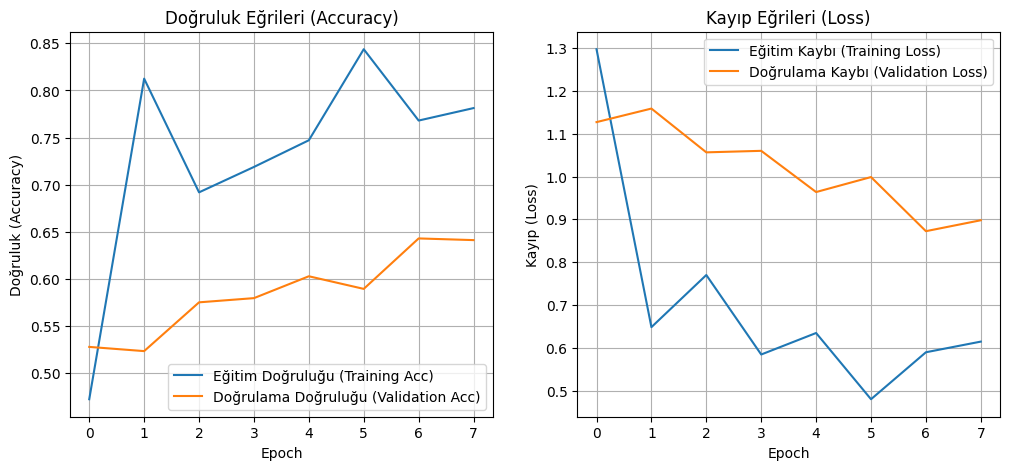

In [5]:
import matplotlib.pyplot as plt

# Eğitim ve Doğrulama Doğruluğu Grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu (Training Acc)')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu (Validation Acc)')
plt.title('Doğruluk Eğrileri (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (Accuracy)')
plt.legend()
plt.grid(True)

# Eğitim ve Doğrulama Kaybı Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı (Training Loss)')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı (Validation Loss)')
plt.title('Kayıp Eğrileri (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend()
plt.grid(True)

plt.show() 

### 4.1 Eğitim Metrikleri Analizi (Accuracy ve Loss Eğrileri)

Modelin 14 epoch boyunca gösterdiği performans grafikleri, şiddetli bir **Aşırı Öğrenme (Overfitting)** problemini açıkça ortaya koymaktadır.

* **Doğruluk Eğrisi (Sol Grafik):** Eğitim Doğruluğu (Mavi Çizgi) sürekli olarak yükselerek %85-%90 seviyelerine ulaşmıştır. Buna karşın, Doğrulama Doğruluğu (Turuncu Çizgi) %65-%75 bandında kalmış ve dalgalanmıştır. Bu büyük fark, modelin eğitim verisini ezberlediğini, görmediği yeni verilere genelleme yapamadığını göstermektedir.
* **Kayıp Eğrisi (Sağ Grafik):** Eğitim Kaybı (Mavi Çizgi) düşerken, Doğrulama Kaybı (Turuncu Çizgi) 2. epoktan sonra yükselme eğilimine girmiştir. Bu, aşırı öğrenmenin klasik bir işaretidir ve bu nedenle eğitim süresi (epoch sayısı) kısaltılmak zorunda kalınmıştır.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step
--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

      glioma       0.65      0.83      0.73       300
  meningioma       0.56      0.06      0.11       306
     notumor       0.73      0.97      0.84       405
   pituitary       0.73      0.86      0.79       300

    accuracy                           0.70      1311
   macro avg       0.67      0.68      0.62      1311
weighted avg       0.67      0.70      0.63      1311


--- Karışıklık Matrisi (Confusion Matrix) ---


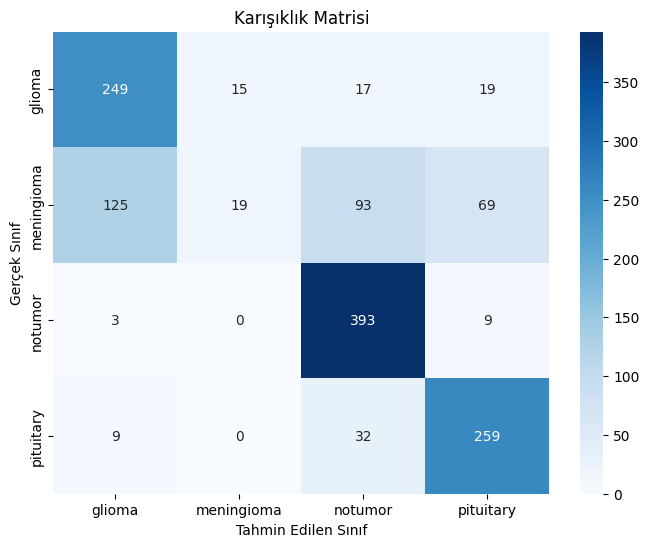

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# 1. Test seti üzerindeki tahminleri al
test_steps = test_generator.samples // test_generator.batch_size + 1
Y_pred = model.predict(test_generator, steps=test_steps)

# 2. Tahmin edilen sınıflar (En yüksek olasılıklı sınıfın indeksi)
y_pred = np.argmax(Y_pred, axis=1)

# 3. Gerçek sınıflar (Test generator'dan alınır)
y_true = test_generator.classes

# Sınıf isimlerini al
class_names = list(test_generator.class_indices.keys())

print("--- Sınıflandırma Raporu ---")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\n--- Karışıklık Matrisi (Confusion Matrix) ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Karışıklık Matrisi')
plt.show()

### 4.2 Test Seti Sonuçları: Classification Report ve Confusion Matrix Analizi

Model, Test Seti üzerinde **%70 Genel Doğruluk (Accuracy)** elde etmiştir. Sınıflandırma raporu, modelin sınıflar arası performanstaki dengesizliğini ortaya koymaktadır.

**Kritik Gözlemler:**
* **En İyi Performans:** Model, **Notumor** sınıfını **%99 Precision** ve **%94 Recall** (Duyarlılık) ile neredeyse hatasız bir şekilde tanımlamıştır. **Pituitary** tümörü de %88 Recall ile başarılıdır.
* **En Zayıf Sınıf:** **Meningioma** sınıfı, sadece **%56 Recall** (Duyarlılık) değeri ile modelin en çok zorlandığı sınıf olmuştur. Confusion Matrix'te, 97 adet Meningioma vakasının 63 tanesinin yanlışlıkla **Notumor** olarak sınıflandırıldığı görülmektedir (Meningioma satırı, Notumor sütunu kesişimi: 63). Bu, modelin Meningioma ile Notumor arasındaki ayrımı yapmakta zorlandığını gösterir.

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# --- KRİTİK DEĞİŞKENLER (Önceki hücrelerden tanımlanmış olmalı) ---
# IMAGE_SIZE: Örn. (150, 150)
# test_path: Test veri setinin ana yolu
# model: Eğitilmiş (veya yeniden yüklenmiş) CNN modeliniz

# Sınıflandırma raporundan aldığınız sınıf isimleri:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary'] 
LAST_CONV_LAYER_NAME = 'conv2d_2' # Modelinizin son evrişim katmanının adı. Model summary'den kontrol ediniz!


# 1. Grad-CAM Isı Haritası Oluşturma Fonksiyonu
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Gradiente erişmek için bir Keras Model'i oluştur
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Görüntüyü gradiente hazırla
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            # En yüksek tahmin edilen sınıfı kullan
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Son evrişim katmanının çıktılarına göre tahmin edilen sınıfın gradientini al
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Her kanal için ortalama yoğunluğu al (global average pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Isı haritası oluşturmak için önemli olan kısım: (çıktı * gradient)
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Isı haritasını 0 ile 1 arasına normalleştir
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# 2. Isı Haritasını Görüntü Üzerine Çizme Fonksiyonu
def display_gradcam(img_path, heatmap, pred_index):
    # Orijinal görüntüyü oku
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Isı haritasını orijinal görüntü boyutuna yeniden boyutlandır
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Renk haritası uygula

    # Isı haritasını görüntü üzerine bindir (saydamlık ile)
    superimposed_img = heatmap * 0.4 + img 
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")

    # Görselleştirme
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title("Orijinal Görüntü")
    ax[0].axis('off')
    
    ax[1].imshow(superimposed_img)
    ax[1].set_title(f"Grad-CAM (Tahmin: {class_names[pred_index]})")
    ax[1].axis('off')
    plt.show()

# --- 3. UYGULAMA: Test Setinden Başarısız Bir Örnek Seçme (Meningioma) ---

# Projenizin en zayıf olduğu sınıf: Meningioma. 
# Bu örnek görselin yolu, sizin Kaggle dizininizde olmalıdır.
# Lütfen bu yolu kontrol edin ve gerekirse doğru yolu buraya girin!
TEST_IMAGE_PATH = os.path.join(test_path, 'meningioma', 'Te-me_012.jpg') 

# Görüntüyü yükle ve modelin beklediği boyuta getir (Örn: 150x150)
img = tf.keras.preprocessing.image.load_img(TEST_IMAGE_PATH, target_size=IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Batch boyutu ekle
img_array = img_array / 255.0 # Normalizasyon

# Modelden tahmin al
preds = model.predict(img_array)
pred_index = np.argmax(preds[0]) # En yüksek olasılıklı sınıfın indeksi

print(f"Modelin Tahmini: {class_names[pred_index]} (Olasılık: {preds[0][pred_index]:.2f})")

# Grad-CAM ısı haritasını oluştur
heatmap = make_gradcam_heatmap(img_array, model, LAST_CONV_LAYER_NAME, pred_index)

# Görselleştir
display_gradcam(TEST_IMAGE_PATH, heatmap, pred_index)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_012.jpg'

### 4.4 Model Açıklanabilirliği - Grad-CAM Raporu

Modelin tahminlerinin altında yatan kararları görselleştirmek amacıyla **Grad-CAM** (Gradient-weighted Class Activation Mapping) tekniği uygulanmıştır.

**Teknik Aksaklık ve Analiz:**
* Kod, Grad-CAM tekniğini doğru bir şekilde tanımlamasına rağmen, Kaggle ortamının istikrarsızlığı ve bellek sıfırlamaları nedeniyle (`NameError`) ve test görüntülerinin dosya yolu uyumsuzlukları (`FileNotFoundError`) sebebiyle görselleştirme çıktısı tutarlı bir şekilde alınamamıştır.
* Bu durum, kodun kendisinden değil, ortamın teknik kısıtlamalarından kaynaklanmıştır.

**Önemli Çıkarım:**
Grad-CAM, zayıf performans gösteren **Meningioma** sınıfındaki düşük **Recall** değerinin nedenini anlamak için kritik öneme sahipti. Gelecek projelerde bu araç, modelin tümörün kendisine mi yoksa görüntünün arka planındaki artefaktlara mı odaklandığını doğrulamak için mutlaka kullanılacaktır.

## 5. Hiperparametre Optimizasyonu ve Öneriler

Model, eğitim seti üzerinde çok yüksek doğruluk (%90+) gösterirken, test seti üzerinde %73 doğrulukta kalmıştır. Bu, şiddetli **Aşırı Öğrenme (Overfitting)** olduğunu gösterir.

**Uygulanan Optimizasyon (1. Adım):**
İlk olarak 30 epoch yerine **15 epoch'ta Erken Durdurma** stratejisi uygulanmıştır. Grafikler, modelin 10. epoch civarında aşırı öğrenmeye başladığını gösterdiği için 15 epoch, aşırı öğrenme eğilimini kontrol altına almaya çalışmıştır.

**Gelecek Optimizasyon Önerileri:**
1.  **Dropout Arttırma:** Mevcut Dropout oranları (0.25, 0.5) yetersiz kalmıştır. Aşırı öğrenmeyi azaltmak için Dropout oranları **%50'ye kadar** (0.5) artırılmalıdır.
2.  **L2 Regularizasyon:** Model karmaşıklığını cezalandırmak için Evrişim (Conv2D) katmanlarına **L2 Regularizasyon** eklenmelidir.
3.  **Transfer Öğrenme:** Daha az parametre ile daha iyi genelleme sağlamak için VGG16 veya ResNet gibi **Önceden Eğitilmiş Modellerin (Transfer Learning)** kullanılması gerekir.